> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: June 17th, 2025. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">[Group 10: 최광일, 정성호]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-06-12 19:09:36.792594


The objective of this assignment is to address the domain generalization problem in neural networks.

In [2]:
# You may change the values below.
team_id = '010' # your team id - should be a three-digit number
root_dir = './PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 10 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model' # model name
TEST_MODE = False # test mode -- evaluation for TAs

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [6]:
class PACSDataset(Dataset):
	def __init__(self, root_dir, domain, transform=None):
		"""
		Args:
			root_dir (string): Directory with all the images.
			domains (list): Containing domains of interest, with element choices: 
				['photo', 'art_painting', 'cartoon', 'sketch'].
			transform (callable, optional): Optional transform to be applied on a sample.
		"""        
		self.root_dir = root_dir
		self.domain = domain
		self.transform = transform

		self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
		self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

		self.images = []
		self.labels = []

		# Load images and labels
		domain_dir = os.path.join(self.root_dir, self.domain)
		for cls_name in self.classes:
			cls_dir = os.path.join(domain_dir, cls_name)
			image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png'))]

			for img_name in image_files:
				self.images.append(os.path.join(cls_dir, img_name))
				self.labels.append(self.class_to_idx[cls_name])

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = self.images[idx]
		image = Image.open(img_path).convert('RGB')
		label = self.labels[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

In [7]:
# Define transforms
transform_train = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_train),
	PACSDataset(root_dir, 'art_painting', transform=transform_train),
	PACSDataset(root_dir, 'sketch', transform=transform_train),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
# Let's visualize some images from the training set

import matplotlib.pyplot as plt
import numpy as np

def visualize_example_images(root_dir, domain):
	assert domain in ['art_painting', 'sketch', 'cartoon']

	def denormalize(tensor):
		"""Denormalize the image tensor for visualization"""
		mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
		std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
		return tensor * std + mean
	
 	# Create dataset
	dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_train)

	# Create a figure with subplots for each class
	fig, axs = plt.subplots(1, 7, figsize=(15, 3))
	fig.suptitle('Sample Images from Each Category')

	# For each class
	for i, class_name in enumerate(dataset.classes):
		# Find first image of this class
		for idx in range(len(dataset)):
			if dataset.labels[idx] == i:
				image, _ = dataset[idx]
				
				# Denormalize the image
				image = denormalize(image)
				
				# Convert to numpy and transpose for plotting
				image = image.numpy().transpose(1, 2, 0)
				
				# Clip values to [0, 1] range
				image = np.clip(image, 0, 1)
				
				# Plot
				axs[i].imshow(image)
				axs[i].set_title(class_name)
				axs[i].axis('off')
				break

	plt.tight_layout()
	plt.show()

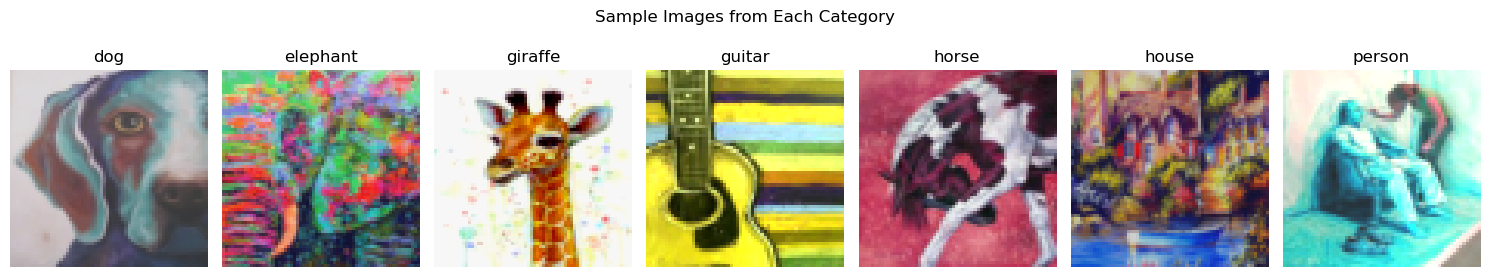

In [17]:
visualize_example_images(root_dir, 'art_painting')

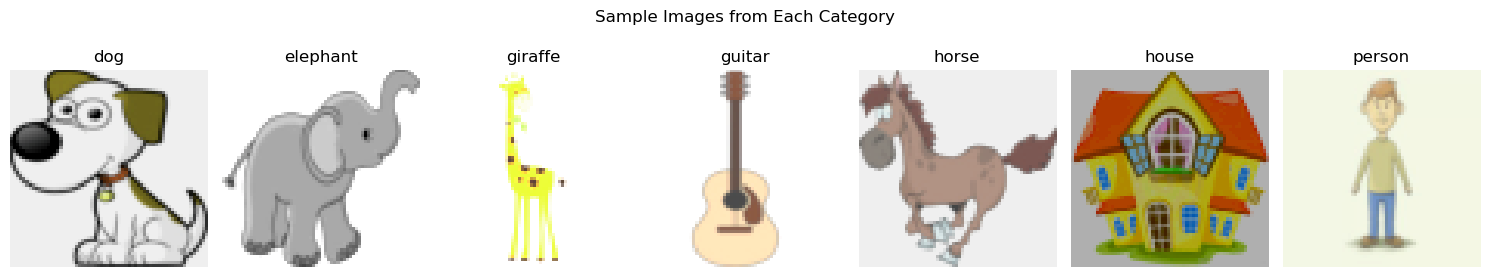

In [55]:
visualize_example_images(root_dir, 'cartoon')

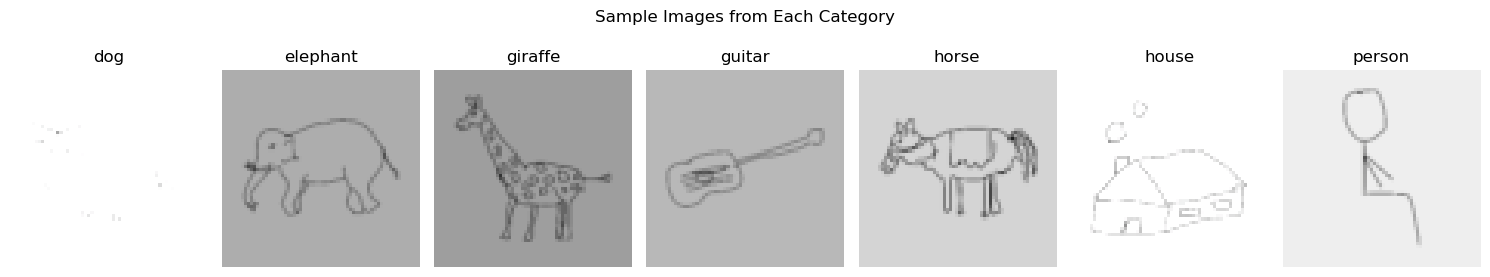

In [56]:
visualize_example_images(root_dir, 'sketch')

In [18]:
# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

In [19]:
# Instantiate loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Epoch 1/10: 100%|██████████| 261/261 [00:15<00:00, 16.71it/s]


Epoch [1/10], Loss: 1.8349, Test Accuracy: 40.48%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:15<00:00, 16.76it/s]


Epoch [2/10], Loss: 1.5451, Test Accuracy: 54.55%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:15<00:00, 16.89it/s]


Epoch [3/10], Loss: 1.3318, Test Accuracy: 58.74%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:15<00:00, 16.91it/s]


Epoch [4/10], Loss: 1.1773, Test Accuracy: 62.28%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:15<00:00, 16.79it/s]


Epoch [5/10], Loss: 1.0584, Test Accuracy: 65.63%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:15<00:00, 16.53it/s]


Epoch [6/10], Loss: 0.9703, Test Accuracy: 64.67%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:15<00:00, 16.73it/s]


Epoch [7/10], Loss: 0.8938, Test Accuracy: 64.19%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:15<00:00, 16.53it/s]


Epoch [8/10], Loss: 0.8431, Test Accuracy: 68.02%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:15<00:00, 16.64it/s]


Epoch [9/10], Loss: 0.8003, Test Accuracy: 66.71%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:15<00:00, 16.65it/s]


Epoch [10/10], Loss: 0.7761, Test Accuracy: 71.20%, Learning Rate: 0.000010
Finished Training


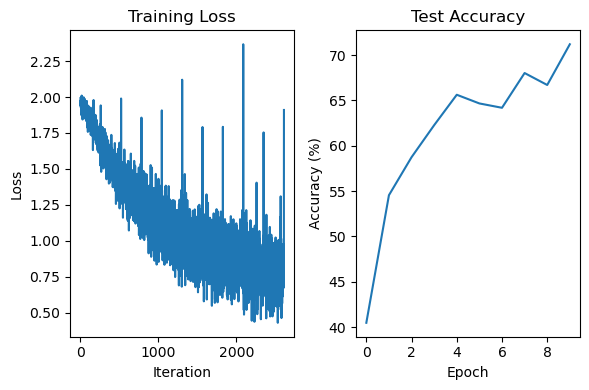

In [60]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model = model.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels = inputs.to(device), labels.to(device)

			optimizer.zero_grad()

			outputs = model(inputs)

			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler.step()

		# Validation
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model.state_dict(), f'./{model_name}_base.pth')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

# Base Model Test

In [61]:
# Load model
del model
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # ✅ pretrained=True와 동일
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 7)  # ✅ PACS용 7개 클래스 출력
state_dict = torch.load(f'./{model_name}_base.pth')   # ✅ weights_only 제거
model.load_state_dict(state_dict)
model.eval()
model.to(device)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        for cls_name in self.class_to_idx.keys():
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test data
root_dir_test = './CuratedPACS'
dataset_test = CustomDataset(root_dir_test, transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # 라벨 문자열 출력
        for t, p in zip(labels.cpu(), predicted.cpu()):
            true_name = dataset_test.idx_to_class[t.item()]
            pred_name = dataset_test.idx_to_class[p.item()]
            print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

C:\Users\user\AppData\Local\Temp\ipykernel_29476\2057990014.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./{model_name}_base.pth')   # ✅ wei

GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: elephant ✅
GT: elephant | Pred: elephant ✅
GT: elephant | Pred: horse    ❌
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: guitar   | Pred: dog      ❌
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: person   ❌
GT: guitar   | Pred: guitar   ✅
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: person   ❌
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: person   ❌
GT: horse    | Pred: person   ❌
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: person   | Pred: person   ✅
GT: pers

# MMD Model Train

In [21]:
class PACSDatasetWithDomain(PACSDataset):
    def __init__(self, root_dir, domain_name, domain_id, transform=None):
        super().__init__(root_dir, domain_name, transform=transform)
        self.domain_id = domain_id

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, label, self.domain_id

# 도메인별 정수 ID 지정
domain_to_id = {'cartoon': 0, 'art_painting': 1, 'sketch': 2}

dataset_train_mmd = ConcatDataset([
    PACSDatasetWithDomain(root_dir, 'cartoon', domain_to_id['cartoon'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'art_painting', domain_to_id['art_painting'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'sketch', domain_to_id['sketch'], transform=transform_train),
])
dataset_test_mmd = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train_mmd = DataLoader(dataset_train_mmd, batch_size=batch_size, shuffle=True)
loader_test_mmd = DataLoader(dataset_test_mmd, batch_size=batch_size, shuffle=False)

In [22]:
# 수정된 ResNet50 with intermediate feature hook
class ResNetWithFeatures(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # fc 제거
        self.fc = nn.Linear(base.fc.in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # flatten
        logits = self.fc(features)
        if return_features:
            return logits, features
        return logits

model_mmd = ResNetWithFeatures(num_classes=7)

In [23]:
# Instantiate loss, optimizer, and scheduler
criterion_mmd = nn.CrossEntropyLoss()
optimizer_mmd = optim.SGD(model_mmd.parameters(), lr=lr, momentum=0.9)
scheduler_mmd = lr_scheduler.StepLR(optimizer_mmd, step_size=step_size, gamma=0.1)

In [12]:
# MMD 구현 함수
def gaussian_kernel(x, y, sigma_val):
    x = x.unsqueeze(1)          # (B,1,D)
    y = y.unsqueeze(0)          # (1,B,D)
    dist = ((x - y) ** 2).sum(2)
    return torch.exp(-dist / (2 * sigma_val ** 2 + 1e-8))

def compute_mmd(x1, x2, sigmas=(1, 2, 4, 8)):
    mmd2 = 0
    for s in sigmas:
        Kxx = gaussian_kernel(x1, x1, s)
        Kyy = gaussian_kernel(x2, x2, s)
        Kxy = gaussian_kernel(x1, x2, s)

        # unbiased: diag 제외
        def off_diag(mat):      # (N,N)
            return mat.sum() - mat.diagonal().sum()

        m = x1.size(0); n = x2.size(0)
        mmd2 += (off_diag(Kxx) / (m*(m-1))
                 + off_diag(Kyy) / (n*(n-1))
                 - 2 * Kxy.mean())
    return mmd2 / len(sigmas)

lambda_mmd = 0.1  # MMD 손실 가중치

In [24]:
# cosine_sim 구현 함수
def cosine_kernel(x, y):
    x = F.normalize(x, dim=1)  # L2 정규화
    y = F.normalize(y, dim=1)
    return x @ y.t()           

def compute_cosine_similarity(x1, x2):
    loss = 0

    Cxy = cosine_kernel(x1, x2)
    
    loss = 1.0 - Cxy.mean()

    return loss

lambda_mmd = 1.0  # MMD 손실 가중치

In [25]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model_mmd = model_mmd.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model_mmd.train()
		running_loss = 0.0
		correct = 0
		total = 0

		cls_tot = 0.0
		cls_cnt = 0
		mmd_tot = 0.0
		mmd_cnt = 0

		for i, (inputs, labels, domains) in enumerate(tqdm(loader_train_mmd, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels, domains = inputs.to(device), labels.to(device), domains.to(device)

			optimizer_mmd.zero_grad()

			outputs, features = model_mmd(inputs, return_features=True)

			loss = criterion_mmd(outputs, labels)

			cls_tot += loss.item()
			cls_cnt += 1

			unique_domains = torch.unique(domains)
			mmd_loss = 0.0
			for di in range(len(unique_domains)):
				for dj in range(di + 1, len(unique_domains)):
					f1 = features[domains == unique_domains[di]]
					f2 = features[domains == unique_domains[dj]]
					if f1.size(0) > 1 and f2.size(0) > 1:
						pair_mmd = compute_mmd(f1, f2)
						mmd_loss += pair_mmd
						mmd_tot  += pair_mmd.item()
						mmd_cnt += 1
      
						# cosine_loss = compute_cosine_similarity(f1, f2)
						# mmd_loss += cosine_loss
						# mmd_tot  += cosine_loss.item()
						# mmd_cnt += 1

			if mmd_cnt > 0:
				mmd_loss = mmd_loss / mmd_cnt

			loss = loss + lambda_mmd * mmd_loss
			loss.backward()
			optimizer_mmd.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler_mmd.step()

		# Validation
		model_mmd.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test_mmd:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs, features = model_mmd(inputs, return_features=True)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer_mmd.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train_mmd):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}, '
					f'Average MMD: {mmd_tot / (mmd_cnt + 1e-5):.4f}, '
					f'Average CLS: {cls_tot / (cls_cnt + 1e-5):.4f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model_mmd.state_dict(), f'./{model_name}_mmd.pth')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

Epoch 1/10:   0%|          | 0/261 [00:00<?, ?it/s]


KeyboardInterrupt: 

# MMD Model Test

In [ ]:
# Load model
del model_mmd
model_mmd = ResNetWithFeatures(num_classes=7)
model_mmd.load_state_dict(torch.load(f'./{model_name}_mmd.pth'))
model_mmd.eval()
model_mmd.to(device)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        for cls_name in self.class_to_idx.keys():
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test data
root_dir_test = './CuratedPACS'
dataset_test = CustomDataset(root_dir_test, transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_mmd(inputs)
        _, predicted = outputs.max(1)

        # 라벨 문자열 출력
        for t, p in zip(labels.cpu(), predicted.cpu()):
            true_name = dataset_test.idx_to_class[t.item()]
            pred_name = dataset_test.idx_to_class[p.item()]
            print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

C:\Users\user\AppData\Local\Temp\ipykernel_20588\819129383.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mmd.load_state_dict(torch.load(f'./{model_name}_cosine_s

GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog 

# FACT Model Train

In [67]:
# Load ResNet50 model pre-trained on ImageNet
model_fact = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
num_features = model_fact.fc.in_features
model_fact.fc = nn.Linear(num_features, 7)

In [68]:
# Instantiate loss, optimizer, and scheduler
criterion_fact = nn.CrossEntropyLoss()
optimizer_fact = optim.SGD(model_fact.parameters(), lr=lr, momentum=0.9)
scheduler_fact = lr_scheduler.StepLR(optimizer_fact, step_size=step_size, gamma=0.1)

In [69]:
import torch.nn.functional as F
from torch.fft import rfft2, irfft2

In [71]:
def amplitude_mix(images, eta=0.5):
    """
    images : (B, C, H, W)  float tensor
    returns: 동일 shape (B, C, H, W)
    """
    B, C, H, W = images.shape
    perm = torch.randperm(B, device=images.device)
    imgs2 = images[perm]

    # FFT
    fft1 = torch.fft.rfft2(images, norm='ortho')
    fft2 = torch.fft.rfft2(imgs2,  norm='ortho')

    amp1, phase1 = torch.abs(fft1), torch.angle(fft1)
    amp2 = torch.abs(fft2)

    # -------- FIXED: 4-D λ --------
    lam = eta * torch.rand(B, 1, 1, 1, device=images.device)
    amp_mix = lam * amp1 + (1 - lam) * amp2
    # ------------------------------

    fft_mix = amp_mix * torch.exp(1j * phase1)
    aug = torch.fft.irfft2(fft_mix, s=(H, W), norm='ortho')

    # 값 범위/자료형 보정
    return aug.clamp_(images.min(), images.max()).type_as(images)



ETA   = 0.3     # Amplitude 혼합 세기
BETA  = 0.25     # Consistency 손실 가중치
TEMP  = 3.0     # Temperature scaling

Epoch 1/10: 100%|██████████| 261/261 [00:17<00:00, 15.16it/s]


Epoch [1/10], Loss: 3.5636, Test Accuracy: 44.43%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:16<00:00, 15.48it/s]


Epoch [2/10], Loss: 2.9297, Test Accuracy: 65.87%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:16<00:00, 15.47it/s]


Epoch [3/10], Loss: 2.5360, Test Accuracy: 69.28%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:16<00:00, 15.49it/s]


Epoch [4/10], Loss: 2.2873, Test Accuracy: 69.22%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:17<00:00, 15.28it/s]


Epoch [5/10], Loss: 2.1088, Test Accuracy: 72.87%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:17<00:00, 15.20it/s]


Epoch [6/10], Loss: 1.9679, Test Accuracy: 73.71%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:17<00:00, 15.32it/s]


Epoch [7/10], Loss: 1.8837, Test Accuracy: 74.61%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:16<00:00, 15.38it/s]


Epoch [8/10], Loss: 1.7761, Test Accuracy: 75.93%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:16<00:00, 15.56it/s]


Epoch [9/10], Loss: 1.6956, Test Accuracy: 79.22%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:16<00:00, 15.62it/s]


Epoch [10/10], Loss: 1.6092, Test Accuracy: 75.63%, Learning Rate: 0.000010
Finished Training


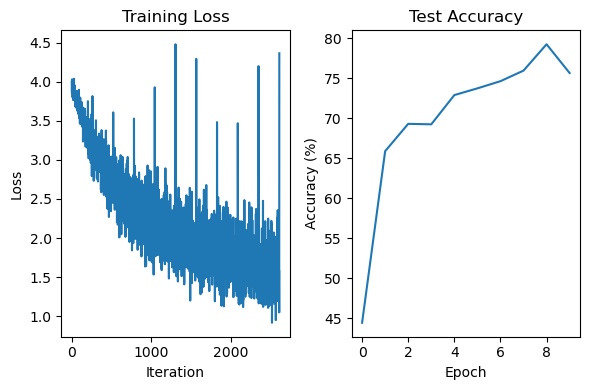

In [ ]:
if not TEST_MODE:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_fact = model_fact.to(device)

    # Lists to store loss and accuracy values
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model_fact.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
            inputs, labels = inputs.to(device), labels.to(device)

            # ① FACT 증강
            inputs_aug = amplitude_mix(inputs, eta=ETA)

            # ② Forward
            outputs_ori = model_fact(inputs)        # 원본
            outputs_aug = model_fact(inputs_aug)    # 증강본

            # ③ 손실 계산
            loss_cls_ori = criterion_fact(outputs_ori, labels)
            loss_cls_aug = criterion_fact(outputs_aug, labels)

            p_ori = F.log_softmax(outputs_ori / TEMP, dim=1)
            q_aug = F.softmax(outputs_aug / TEMP, dim=1)
            p_aug = F.log_softmax(outputs_aug / TEMP, dim=1)
            q_ori = F.softmax(outputs_ori / TEMP, dim=1)
            loss_cons = (F.kl_div(p_ori, q_aug, reduction='batchmean') +
                        F.kl_div(p_aug, q_ori, reduction='batchmean')) * (TEMP ** 2) / 2

            loss = loss_cls_ori + loss_cls_aug + BETA * loss_cons

            # ④ Back-prop
            optimizer_fact.zero_grad()

            loss.backward()
            optimizer_fact.step()

            running_loss += loss.item()
            _, predicted = outputs_ori.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store loss at every iteration
            train_losses.append(loss.item())

        scheduler_fact.step()

        # Validation
        model_fact.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader_test:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_fact(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        current_lr = optimizer_fact.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Loss: {running_loss/len(loader_train):.4f}, '
                    f'Test Accuracy: {test_accuracy:.2f}%, '
                    f'Learning Rate: {current_lr:.6f}')

    print('Finished Training')

    # Save the model - make sure you include this file in your submission
    torch.save(model_fact.state_dict(), f'./{model_name}_fact.pth')

    # Plotting after training is finished
    plt.figure(figsize=(6, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

# FACT Model Test

In [ ]:
# Load model
del model_fact
model_fact = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # ✅ pretrained=True와 동일
num_features = model_fact.fc.in_features
model_fact.fc = torch.nn.Linear(num_features, 7)  # ✅ PACS용 7개 클래스 출력
state_dict = torch.load(f'./{model_name}_fact.pth')   # ✅ weights_only 제거
model_fact.load_state_dict(state_dict)
model_fact.eval()
model_fact.to(device)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        for cls_name in self.class_to_idx.keys():
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test data
root_dir_test = './CuratedPACS'
dataset_test = CustomDataset(root_dir_test, transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_fact(inputs)
        _, predicted = outputs.max(1)

        # 라벨 문자열 출력
        for t, p in zip(labels.cpu(), predicted.cpu()):
            true_name = dataset_test.idx_to_class[t.item()]
            pred_name = dataset_test.idx_to_class[p.item()]
            print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

C:\Users\user\AppData\Local\Temp\ipykernel_29476\3816558701.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./{model_name}_fact.pth')   # ✅ wei

GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: elephant | Pred: elephant ✅
GT: elephant | Pred: elephant ✅
GT: elephant | Pred: dog      ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: horse    ❌
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: guitar   | Pred: person   ❌
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: dog      ❌
GT: guitar   | Pred: person   ❌
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: giraffe  ❌
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: dog      ❌
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: person   | Pred: person   ✅
GT: pers

# TA TEST

In [ ]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}.pth'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')